This notebook documents the process of parsing the json drug label files from openFDA

In [1]:
import os
import json
import zipfile
import glob
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_dir="../../data/"
try:
    os.mkdir(data_dir)
except:
    print(data_dir+' exists')
downloads_dir=data_dir+"downloads/"
try:
    os.mkdir(downloads_dir)
except:
    print(downloads_dir+' exists')
    
out = data_dir+"parsed/"
try:
    os.mkdir(out)
except:
    print(out+' exists')
out_meta = out+"meta/"
try:
    os.mkdir(out_meta)
except:
    print(out_meta+' exists')

../../data/ exists
../../data/downloads/ exists
../../data/parsed/ exists
../../data/parsed/meta/ exists


In [3]:
drug_label_files = glob.glob(downloads_dir+"*.json.zip")

In [21]:
dfs = []
drug_label_file = drug_label_files[0]
for drug_label_file in drug_label_files:
    z = zipfile.ZipFile(drug_label_file, "r")
    for filename in z.namelist():   
        t0 = time.time()

        print(filename) 
        file_lst = filename.split('.')
        out_file = '_'.join(file_lst[:1])
        with z.open(filename) as f:  
            data = f.read()  
            d = json.loads(data.decode("utf-8"))

            meta = pd.json_normalize(d['meta'])
            (meta.
             to_csv(out_meta+out_file+'_meta.csv.gzip',
                        compression='gzip'))
            
            results = pd.json_normalize(d['results'])
            results.index = results['set_id'].values
            
            print('Parsing...')
            t0 = time.time()
            subs = []
            #fields = results.columns.sort_values().values
            fields = ['openfda.rxcui',
                      'openfda.unii',
                      'effective_time',
                      'animal_pharmacology_and_or_toxicology',
                     'keep_out_of_reach_of_children',
                      'pediatric_use'
                     ]
            n=results.shape[0]
            for field in fields:
                sub = \
                (pd.concat(
                    {k: pd.Series(v) for k, v in results.head(n)[field].items()}
                ).
                 reset_index().
                 drop('level_1',axis=1).
                 rename(columns={'level_0' : 'set_id',0 : field}).
                 set_index('set_id')
                )
                subs.append(sub)

            df = pd.concat(subs, axis=0)
            t1 = time.time()
            print(np.round(t1-t0,2),' seconds')
            
            dfs.append(df)

drug-label-0003-of-0009.json
Parsing...
15.0  seconds
drug-label-0008-of-0009.json
Parsing...
14.48  seconds
drug-label-0007-of-0009.json
Parsing...
14.46  seconds
drug-label-0002-of-0009.json
Parsing...
15.05  seconds
drug-label-0009-of-0009.json
Parsing...
10.47  seconds
drug-label-0006-of-0009.json
Parsing...
15.52  seconds
drug-label-0001-of-0009.json
Parsing...
14.91  seconds
drug-label-0005-of-0009.json
Parsing...
15.53  seconds
drug-label-0004-of-0009.json
Parsing...
16.41  seconds


In [36]:
df = pd.concat(dfs).sort_values('effective_time').reset_index().groupby('set_id').last()

In [37]:
display(df.head())
print("# unique labels: ",df.index.nunique())
for f in df.columns:
    print("# unique labels with ",f,": ",df.dropna(subset=[f]).index.nunique())
    print("% labels with ",f,": ",df.dropna(subset=[f]).index.nunique()/df.index.nunique())

,openfda.rxcui,openfda.unii,effective_time,animal_pharmacology_and_or_toxicology,keep_out_of_reach_of_children,pediatric_use
set_id,,,,,,
0000025c-6dbf-4af7-a741-5cbacaed519a,NaN,NaN,20151102,NaN,Keep this and all medication out of reach of c...,NaN
0000076a-fc39-4208-ace8-6c2cb367904f,NaN,NaN,20150109,NaN,Keep out of reach of children If product is sw...,NaN
00006ebc-ec2b-406c-96b7-a3cc422e933f,NaN,X2N6E405GV,20180801,NaN,KEEP OUT OF REACH OF CHILDREN Keep this and al...,NaN
00011703-bc55-4c0c-858c-149dc674bc3c,NaN,NaN,20171230,NaN,NaN,Pediatric use: Safety and effectiveness in inf...
000155a8-709c-44e5-a75f-cd890f3a7caf,198014,57Y76R9ATQ,20190124,NaN,NaN,8.4 Pediatric Use Safety and effectiveness in ...


# unique labels:  173318
# unique labels with  openfda.rxcui :  53079
% labels with  openfda.rxcui :  0.3062520915311739
# unique labels with  openfda.unii :  90273
% labels with  openfda.unii :  0.5208518445862519
# unique labels with  effective_time :  173318
% labels with  effective_time :  1.0
# unique labels with  animal_pharmacology_and_or_toxicology :  7551
% labels with  animal_pharmacology_and_or_toxicology :  0.043567315570223517
# unique labels with  keep_out_of_reach_of_children :  104989
% labels with  keep_out_of_reach_of_children :  0.6057593556353063
# unique labels with  pediatric_use :  46403
% labels with  pediatric_use :  0.2677332994841851


In [38]:
print(results.shape)
results.head()

(20000, 163)


,package_label_principal_display_panel,description,effective_time,spl_product_data_elements,version,warnings_and_cautions,id,set_id,carcinogenesis_and_mutagenesis_and_impairment_of_fertility,pregnancy,...,components,teratogenic_effects_table,food_safety_warning,drug_and_or_laboratory_test_interactions_table,nonteratogenic_effects_table,accessories,troubleshooting,assembly_or_installation_instructions,environmental_warning,summary_of_safety_and_effectiveness
9367137e-200c-48c6-9634-135e1faeb101,[LABEL IMAGE LABEL IMAGE],[DESCRIPTION Phenytoin sodium is an antiepilep...,20100219,[PHENYTOIN ER PHENYTOIN SODIUM PHENYTOIN SODIU...,1,[CLINICAL PHARMACOLOGY Phenytoin is an antiepi...,c4783156-8357-488d-aaf4-83b1e5978529,9367137e-200c-48c6-9634-135e1faeb101,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51132e43-6fda-4cd4-a818-cfd399264e89,[PACKAGE LABEL.PRINCIPAL DISPLAY PANEL- 250 mg...,[DESCRIPTION Divalproex sodium is a stable co-...,20131229,[Divalproex Sodium Divalproex Sodium DIVALPROE...,1,NaN,c587a83e-6bd2-4645-8044-0884fbb2bc4f,51132e43-6fda-4cd4-a818-cfd399264e89,"[Carcinogenesis, Mutagenesis, Impairment of Fe...",[Pregnancy Pregnancy category D See WARNINGS ....,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aa5fa6bc-87ba-4e8c-e053-2a95a90a7ded,[500 mL],NaN,20200713,[BioMiracle staysafe HAND SANITIZER ALCOHOL GL...,1,NaN,aa5fa38b-80a4-0d53-e053-2995a90a8de1,aa5fa6bc-87ba-4e8c-e053-2a95a90a7ded,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
a062586b-fc78-462c-848d-bc11d06b421d,[nm-good-mood-enhancer.jpg],NaN,20200714,"[Good Mood Enhancer Agrimonia eupatoria, flos,...",3,NaN,aa6b1be3-4086-4789-e053-2a95a90a0a7a,a062586b-fc78-462c-848d-bc11d06b421d,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aa6bf8e8-9287-0ea1-e053-2a95a90a1d08,[Package Label - Principal Display Panel 3785....,NaN,20200714,[Hand Sanitizer ALCOHOL TROLAMINE ALOE VERA LE...,1,NaN,aa6bf8e8-9279-0ea1-e053-2a95a90a1d08,aa6bf8e8-9287-0ea1-e053-2a95a90a1d08,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
results.columns.sort_values().values

array(['abuse', 'accessories', 'active_ingredient',
       'active_ingredient_table', 'adverse_reactions',
       'adverse_reactions_table', 'animal_pharmacology_and_or_toxicology',
       'animal_pharmacology_and_or_toxicology_table', 'ask_doctor',
       'ask_doctor_or_pharmacist', 'ask_doctor_or_pharmacist_table',
       'ask_doctor_table', 'assembly_or_installation_instructions',
       'boxed_warning', 'boxed_warning_table',
       'carcinogenesis_and_mutagenesis_and_impairment_of_fertility',
       'carcinogenesis_and_mutagenesis_and_impairment_of_fertility_table',
       'cleaning', 'clinical_pharmacology', 'clinical_pharmacology_table',
       'clinical_studies', 'clinical_studies_table', 'components',
       'contraindications', 'contraindications_table',
       'controlled_substance', 'dependence', 'description',
       'description_table', 'disposal_and_waste_handling', 'do_not_use',
       'do_not_use_table', 'dosage_and_administration',
       'dosage_and_administration_ta

Text(0.5, 1.0, 'Label field NA distribution for 1 of 9 samples')

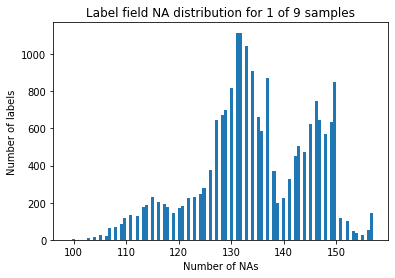

In [40]:
plt.hist(results.apply(lambda x : x.isna().sum(),1).sort_values().values,bins=100)
plt.xlabel("Number of NAs")
plt.ylabel("Number of labels")
plt.title("Label field NA distribution for 1 of 9 samples")

Text(0.5, 1.0, 'Label field NA distribution for 1 of 9 samples')

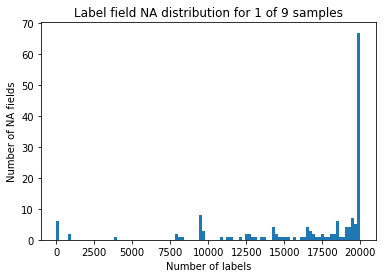

In [41]:
plt.hist(results.apply(lambda x : x.isna().sum(),0).sort_values().values,bins=100)
plt.xlabel("Number of labels")
plt.ylabel("Number of NA fields")
plt.title("Label field NA distribution for 1 of 9 samples")

In [48]:
df['pediatric_use'].value_counts().head(10)

Pediatric Use Safety and effectiveness in pediatric patients have not been established.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [55]:
df['pediatric_use'].str.contains('have not been established').value_counts()

True     28995
False    17408
Name: pediatric_use, dtype: int64

In [65]:
(df['pediatric_use'].
 dropna()[
     ~df['pediatric_use'].
     dropna().
     str.
     contains('have not been established')
 ].
 value_counts().
head(10))

Pediatric Use The efficacy and safety of corticosteroids in the pediatric population are based on the well-established course of effect of corticosteroids, which is similar in pediatric and adult populations. Published studies provide evidence of efficacy and safety in pediatric patients for the treatment of nephrotic syndrome (patients >2 years of age), and aggressive lymphomas and leukemias (patients >1 month of age). Other indications for pediatric use of corticosteroids, e.g., severe asthma and wheezing, are based on adequate and well-controlled trials conducted in adults, on the premises that the course of the diseases and their pathophysiology are considered to be substantially similar in both populations. The adverse effects of corticosteroids in pediatric patients are similar to those in adults (see ADVERSE REACTIONS ). Like adults, pediatric patients should be carefully observed with frequent measurements of blood pressure, weight, height, intraocular pressure, and clinical ev

In [68]:
df.to_csv('../../data/openfda_drug_labels_pediatric_table.csv')